# Code

## Preparing Enviroment
First we start by importing the nessecry libiraries into our enviromet.

In [5]:
#Importing nessecary liberaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from xgboost import XGBRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display
import ipywidgets as widgets
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Data Acquisition
Out dataset came from social computing research conducted at the University of Minnesota by GroupLens orgnization.

Click the following link <https://files.grouplens.org/datasets/movielens/ml-25m.zip> to find the original source of dataset we used.

### Reading and storing the data
We used *panda.read_csv()* method from Pandas libirary to transform the dataset from csv formate into a dataframe formate with indexed columns and raws, which will help us retrieve the data and furher process it.

In [6]:
#Reading data from CSV file to Pandas dataframe
df_movies = pd.read_csv("movies.csv")
df_ratings = pd.read_csv("ratings.csv")

In [7]:
#Showing movies data frame
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
62418,209157,We (2018),Drama
62419,209159,Window of the Soul (2001),Documentary
62420,209163,Bad Poems (2018),Comedy|Drama
62421,209169,A Girl Thing (2001),(no genres listed)


In [8]:
#Showing ratings data frame
df_ratings

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


## Data Cleaning and Processing
We used *pandas.isnull().sum()*, panda.index, and *pandas.dropna()* from pandas libirary, and *re.sub()* from re libirary to clean our dataset.

In [9]:
#Checking for null values in movies dataframe
df_movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

We did't find any null values in movies data farme to deal with.

In [10]:
#Checking for null values in rating dataframe
df_ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

We find one null values in ratings data farme to deal with.

Lets investigate this observation.

In [11]:
#Showing the observation with null value in rating dataframe
df_ratings.iloc[df_ratings[df_ratings['rating'].isnull()].index]

,userId,movieId,rating,timestamp


In [12]:
#Showing the observation with null value in timestamp dataframe
df_ratings.iloc[df_ratings[df_ratings['timestamp'].isnull()].index]

,userId,movieId,rating,timestamp


The missing value occurce in one observation in rating dataset.

We will drop the row with missing observation.

In [13]:
#Droping missing values in the dataset
df_ratings.dropna()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


Now, we will clean Title column in movies dataframe to be search frindly using regular expression (re) libirary.

In [14]:
#This function remove non numeric or alphabitical character from the title text
def title_cleaning(title_text):
    CleanTitle = re.sub("[^a-zA-Z0-9 ]", "", title_text)
    return CleanTitle

In [15]:
#Applying the function
df_movies["title"] = df_movies["title"].apply(title_cleaning)

In [16]:
df_movies

,movieId,title,genres
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji 1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men 1995,Comedy|Romance
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II 1995,Comedy
...,...,...,...
62418,209157,We 2018,Drama
62419,209159,Window of the Soul 2001,Documentary
62420,209163,Bad Poems 2018,Comedy|Drama
62421,209169,A Girl Thing 2001,(no genres listed)


In [17]:
df_movies.shape

(62423, 3)

Since our data shape is so big for juypter noote book to handle, we will cut down the observation from >25 million to <1 million by including the data for the first 1000 movie by movieId

In [18]:
len(df_movies.movieId.unique())

62423

We have 62423 unique movie id. Since, id includes gaps we will select the first 1000 movie by index.

In [19]:
df_movies_lite = df_movies[:1000]

In [20]:
df_movies_lite

,movieId,title,genres
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji 1995,Adventure|Children|Fantasy
2,3,Grumpier Old Men 1995,Comedy|Romance
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance
4,5,Father of the Bride Part II 1995,Comedy
...,...,...,...
995,1018,That Darn Cat 1965,Children|Comedy|Mystery
996,1019,20000 Leagues Under the Sea 1954,Adventure|Drama|Sci-Fi
997,1020,Cool Runnings 1993,Comedy
998,1021,Angels in the Outfield 1994,Children|Comedy


On our way to process the data for EDA, we need to extract the genres from our gener column and hot encode it.

In [21]:
#Getting the unique values and storing it.
genres_array = df_movies_lite['genres'].unique()
genres_array

array(['Adventure|Animation|Children|Comedy|Fantasy',
       'Adventure|Children|Fantasy', 'Comedy|Romance',
       'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller',
       'Adventure|Children', 'Action', 'Action|Adventure|Thriller',
       'Comedy|Horror', 'Adventure|Animation|Children', 'Drama',
       'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance',
       'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller',
       'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi',
       'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi',
       'Mystery|Sci-Fi|Thriller', 'Adventure|Romance|IMAX',
       'Documentary|IMAX', 'Children|Comedy', 'Drama|War',
       'Action|Crime|Drama', 'Action|Adventure|Fantasy',
       'Comedy|Drama|Thriller', 'Mystery|Thriller',
       'Animation|Children|Drama|Musical|Romance',
       'Crime|Mystery|Thriller', 'Action|Drama|Thriller',
       'Adventure|Drama', 'Adventure|Children|Comedy|Fantasy',
       'Drama|Mystery', 'D

Creating the function

In [22]:
#This function extract unique genres from the genre column
def get_genres_list(genres_array):
  gnres_list = []
  for text in genres_array:
    if "|" in text:
      list_genres = text.split("|")
      for genre in list_genres:
        gnres_list.append(genre)
    else:
      gnres_list.append(text)
  #we transformed the list values to dictionary keys to remove dublicated values then reversed it back to list
  gnres_list = list(dict.fromkeys(gnres_list))
  return gnres_list

In [23]:
#Checking the function
genres = get_genres_list(genres_array)
genres

['Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'Mystery',
 'Sci-Fi',
 'IMAX',
 'Documentary',
 'War',
 'Musical',
 'Western',
 'Film-Noir']

Now, we will cread dummy columns for genres filled with 0 value.

In [24]:
for genre in genres:
  df_movies_lite[genres] = 0

In [25]:
df_movies_lite

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji 1995,Adventure|Children|Fantasy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men 1995,Comedy|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II 1995,Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1018,That Darn Cat 1965,Children|Comedy|Mystery,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,1019,20000 Leagues Under the Sea 1954,Adventure|Drama|Sci-Fi,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,1020,Cool Runnings 1993,Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1021,Angels in the Outfield 1994,Children|Comedy,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we will fill it with the correct lable number (1 or 0)

In [26]:
def get_genres_dummies(df, genres_unique):
  i = 0
  for row in df.genres:
    j = 3
    for genre in genres_unique:
      if genre in row:
        df.iloc[i,j] = 1
      j+=1
    i+=1
  return df

In [27]:
df_movies_lite = get_genres_dummies(df_movies_lite, genres)

In [28]:
df_movies_lite

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji 1995,Adventure|Children|Fantasy,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men 1995,Comedy|Romance,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale 1995,Comedy|Drama|Romance,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II 1995,Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1018,That Darn Cat 1965,Children|Comedy|Mystery,0,0,1,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
996,1019,20000 Leagues Under the Sea 1954,Adventure|Drama|Sci-Fi,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
997,1020,Cool Runnings 1993,Comedy,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1021,Angels in the Outfield 1994,Children|Comedy,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We will join our two dataframs on moviesId column to get inshights and analyis the data.

In [29]:
#Left join the dataframes on movieId column
df_reommendations = df_movies_lite.merge(df_ratings, on='movieId', how='left')

In [30]:
df_reommendations

,movieId,title,genres,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,...,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,userId,rating,timestamp
0,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,2,3.5,1141415820
1,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,3,4.0,1439472215
2,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,4,3.0,1573944252
3,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,5,4.0,858625949
4,1,Toy Story 1995,Adventure|Animation|Children|Comedy|Fantasy,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,8,4.0,890492517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466507,1022,Cinderella 1950,Animation|Children|Fantasy|Musical|Romance,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,162512,4.0,1121322368
5466508,1022,Cinderella 1950,Animation|Children|Fantasy|Musical|Romance,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,162516,3.0,1074286617
5466509,1022,Cinderella 1950,Animation|Children|Fantasy|Musical|Romance,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,162519,2.0,1000947589
5466510,1022,Cinderella 1950,Animation|Children|Fantasy|Musical|Romance,0,1,1,0,1,1,0,...,0,0,0,0,1,0,0,162524,3.5,1072919246


## Exploratory Data Analysis (EDA)
In this part We will explore the data by analyising movies ratings on context of geners and users count.

We used pandas.info, pandas.dtype, pandas.join to explore the data by applying EDA technique.

Lets start our EDA.

We will start by asking, what are the most 10 rated movies?

In [31]:
#Calculating the most rated movies and select the top 10
top10_movies = df_reommendations.groupby('title').count()
top10_movies = top10_movies.userId.sort_values(ascending=False)[:10]
top10_movies

title
Forrest Gump 1994                        81491
Shawshank Redemption The 1994            81482
Pulp Fiction 1994                        79672
Silence of the Lambs The 1991            74127
Star Wars Episode IV  A New Hope 1977    68717
Jurassic Park 1993                       64144
Schindlers List 1993                     60411
Braveheart 1995                          59184
Terminator 2 Judgment Day 1991           57379
Toy Story 1995                           57309
Name: userId, dtype: int64

Text(0, 0.5, 'Count')

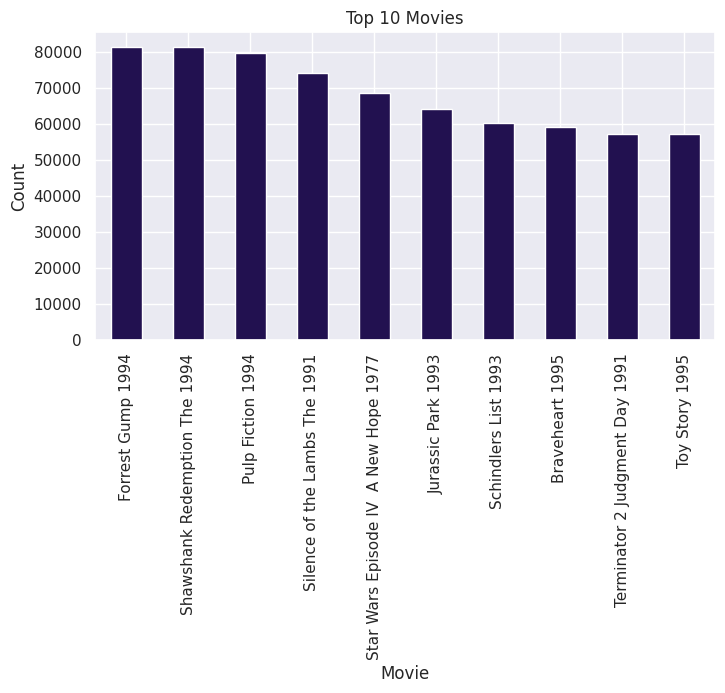

In [32]:
#Ploting the insghts
plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.set_palette("magma")
top10_movies.plot(kind="bar")
plt.title("Top 10 Movies")
plt.xlabel("Movie")
plt.ylabel("Count")

Now, lets see the hight 10 movies by average rating.

In [33]:
df_top10_rating = df_reommendations[['title','rating']]

In [34]:
#Calculating the average rating for the movies and select the top 10
top10_rating = df_top10_rating.groupby('title').mean()
top10_rating = top10_rating.rating.sort_values(ascending=False)[:10]
top10_rating

title
Shawshank Redemption The 1994                                              4.413576
Godfather The 1972                                                         4.324336
Usual Suspects The 1995                                                    4.284353
Schindlers List 1993                                                       4.247579
Rear Window 1954                                                           4.237948
Dr Strangelove or How I Learned to Stop Worrying and Love the Bomb 1964    4.215804
Casablanca 1942                                                            4.206564
Sunset Blvd aka Sunset Boulevard 1950                                      4.206501
North by Northwest 1959                                                    4.196617
Pulp Fiction 1994                                                          4.188912
Name: rating, dtype: float64

Text(0, 0.5, 'Average Rating')

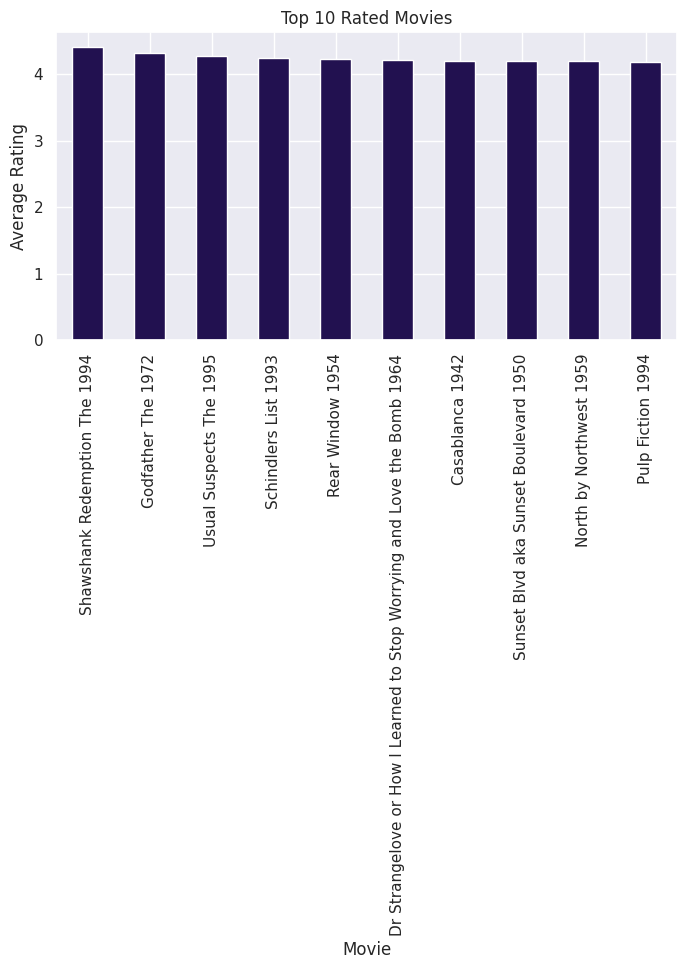

In [35]:
#Ploting the insghts
plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.set_palette("magma")
top10_rating.plot(kind="bar")
plt.title("Top 10 Rated Movies")
plt.xlabel("Movie")
plt.ylabel("Average Rating")

Who are the most 10 rating users?

In [36]:
#Calculating the most rating users and select the top 10
top10_users = df_reommendations.groupby('userId').count()
top10_users = top10_users.movieId.sort_values(ascending=False)[:10]
top10_users

userId
122011    897
83094     883
31171     853
80974     814
72315     711
116178    665
20055     665
57548     633
92975     633
6039      625
Name: movieId, dtype: int64

Text(0, 0.5, 'Movies Rated')

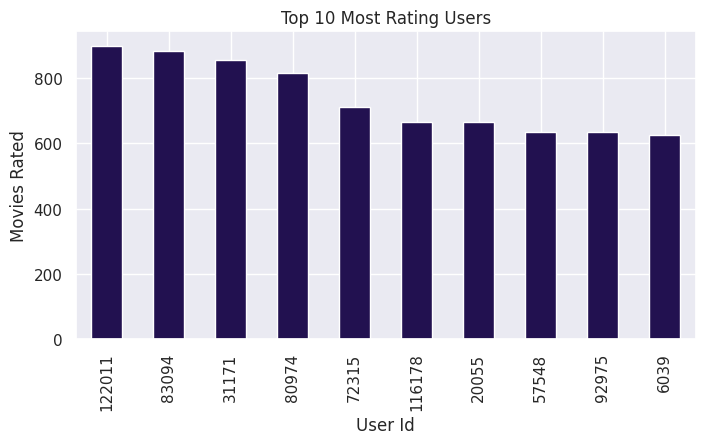

In [37]:
#Ploting the insghts
plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.set_palette("magma")
top10_users.plot(kind="bar")
plt.title("Top 10 Most Rating Users")
plt.xlabel("User Id")
plt.ylabel("Movies Rated")

What is the average rating  for each of the most rating users?

In [38]:
df_user_avg_rating = df_reommendations[['userId','rating']]

In [39]:
to_10_users = top10_users.index.tolist()
to_10_users

[122011, 83094, 31171, 80974, 72315, 116178, 20055, 57548, 92975, 6039]

In [40]:
#Calculating the average rating for the movies and select the top 10
user_avg_rating = df_user_avg_rating.groupby('userId').mean()
user_avg_rating = user_avg_rating[user_avg_rating.index.isin(to_10_users)]
user_avg_rating

,rating
userId,
6039,3.617600
20055,3.212782
31171,3.009379
57548,1.075829
72315,3.214487
80974,3.394349
83094,2.526614
92975,2.540284
116178,2.548872


In [41]:
top10_users = top10_users.to_frame()
user_avg_rating = top10_users.join(user_avg_rating)
user_avg_rating = user_avg_rating.drop(user_avg_rating.columns[0], axis=1)
user_avg_rating

,rating
userId,
122011,2.447046
83094,2.526614
31171,3.009379
80974,3.394349
72315,3.214487
116178,2.548872
20055,3.212782
57548,1.075829
92975,2.540284


Text(0, 0.5, 'Average Rating')

<Figure size 800x400 with 0 Axes>

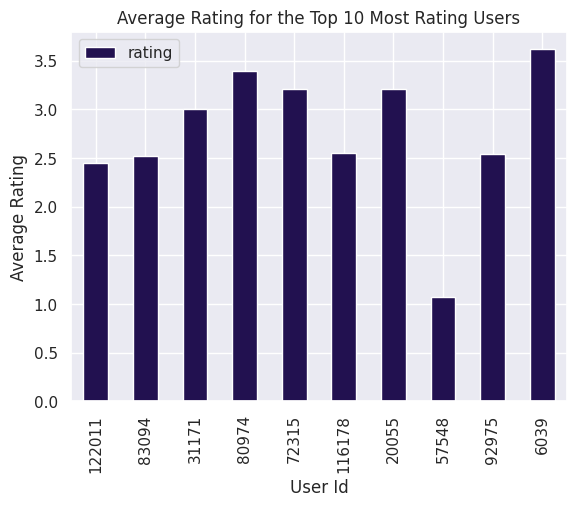

In [42]:
#Ploting the insghts
plt.figure(figsize=(8, 4))
sns.set_theme(style="darkgrid")
sns.set_palette("magma")
user_avg_rating.plot(kind="bar")
plt.title("Average Rating for the Top 10 Most Rating Users")
plt.xlabel("User Id")
plt.ylabel("Average Rating")

What are the most common genres for the movies?

In [43]:
#Ectract desired columns
df_gners  = df_reommendations[df_reommendations.columns.intersection(genres)]
df_gners

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5466507,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5466508,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5466509,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
5466510,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [44]:
geners_frequency_rank = df_gners.sum().sort_values(ascending= False)
geners_frequency_rank

Drama          2361436
Comedy         2020745
Thriller       1773032
Action         1511732
Romance        1228684
Adventure      1219206
Crime          1082839
Sci-Fi          720442
Children        618366
Fantasy         500480
Mystery         418909
War             346282
Animation       343169
Musical         297416
Horror          227646
Western         147180
IMAX            126985
Film-Noir        37479
Documentary      24597
dtype: int64

Text(0, 0.5, 'Number of Movies')

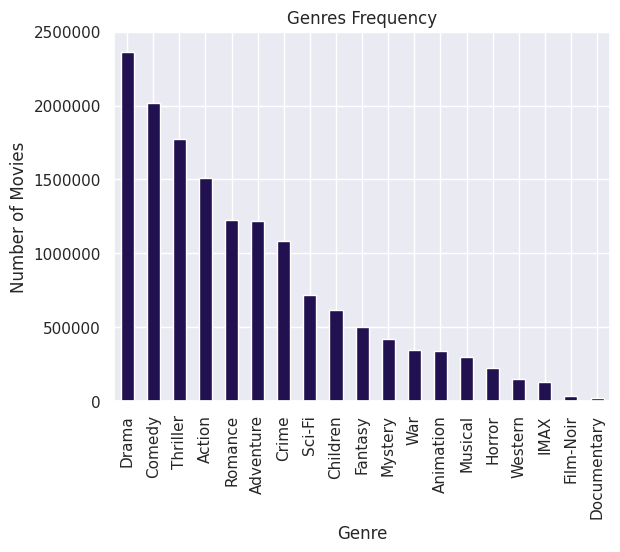

In [45]:
#Ploting the insghts
fig, ax = plt.subplots()
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
sns.set_theme(style="darkgrid")
sns.set_palette("magma")
axies = geners_frequency_rank.plot(kind="bar")
axies.set_ylim(0,2500000)
plt.title("Genres Frequency")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")

Now, we would like to know the average rating for Comedy/Non-Comedy movies.

In [46]:
df_comedy_rating = df_reommendations[['Comedy','rating']]
comedy_rating = df_comedy_rating.groupby('Comedy').mean()
comedy_rating

,rating
Comedy,
0,3.628589
1,3.416909


Text(0, 0.5, 'Average Rating')

<Figure size 800x400 with 0 Axes>

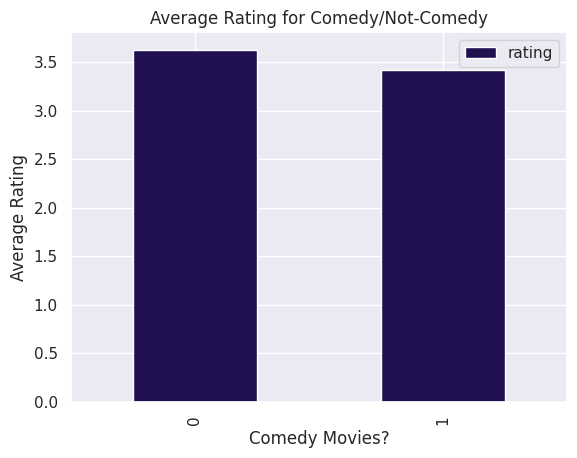

In [47]:
#Ploting the insghts
plt.figure(figsize=(8, 4))
comedy_rating.plot(kind="bar")
plt.title("Average Rating for Comedy/Not-Comedy")
plt.xlabel("Comedy Movies?")
plt.ylabel("Average Rating")

## Data Modeling

We want to predict the expected average rating for the new released movies based on its genres.

We will build a machine learning models to predict movies average rating for newl released movies.

### Features and Target Extraction

First, we will extrat out input and target features from the data.

In [48]:
input_names = genres
input_names.append('title')

In [49]:
#Input Features
df_inputs  = df_movies_lite[df_movies_lite.columns.intersection(input_names)]
df_inputs.set_index('title', inplace=True)
df_inputs

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
title,,,,,,,,,,,,,,,,,,,
Toy Story 1995,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Jumanji 1995,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Grumpier Old Men 1995,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Waiting to Exhale 1995,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Father of the Bride Part II 1995,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
That Darn Cat 1965,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
20000 Leagues Under the Sea 1954,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
Cool Runnings 1993,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
#Target Feature
df_ave_rate = df_reommendations[['title','rating']]
df_ave_rate = df_ave_rate.groupby('title').mean()
df_ave_rate

,rating
title,
1900 06 1994,3.378261
2 Days in the Valley 1996,3.278028
20000 Leagues Under the Sea 1954,3.544120
2001 A Space Odyssey 1968,3.981350
301 302 301302 1995,3.006849
...,...
World of Apu The Apur Sansar 1959,4.111486
Wyatt Earp 1994,3.199915
Yankee Zulu 1994,2.555556


Now we will merge on index to organize the data values.

In [51]:
df_x_y = df_inputs.join(df_ave_rate)
df_x_y

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,rating
title,,,,,,,,,,,,,,,,,,,,
Toy Story 1995,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.893708
Jumanji 1995,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.251527
Grumpier Old Men 1995,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.142028
Waiting to Exhale 1995,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2.853547
Father of the Bride Part II 1995,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.058434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
That Darn Cat 1965,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3.081069
20000 Leagues Under the Sea 1954,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,3.544120
Cool Runnings 1993,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.258671


In [52]:
#Selection
X = df_x_y[df_x_y.columns.intersection(genres)]
X = X.reset_index(drop=True)
X

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir
0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
996,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
997,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [53]:
y = df_x_y['rating']
y = y.reset_index(drop=True)
y

0      3.893708
1      3.251527
2      3.142028
3      2.853547
4      3.058434
         ...   
995    3.081069
996    3.544120
997    3.258671
998    2.824153
999    3.556909
Name: rating, Length: 1000, dtype: float64

Now, we will build our models.

### Linear Regression
we will use sklearn libirary to perform linear regression model

In [54]:
#bulding the model function
def Linear_Regression(X,y):
  X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)
  model = LinearRegression()
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print('Mean Squared Error =', mean_squared_error(y_test,y_pred))
  return y_pred

In [55]:
Linear_rates = Linear_Regression(X,y)

Mean Squared Error = 0.1829971223587257


### XGBoost
we will use sklearn libirary to perform XGBoost regression model

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=2529)
#Model initiation
XGBModel = XGBRegressor()
XGBModel.fit(X_train,y_train , verbose=False)

#Predictions and Validation
XGBpredictions = XGBModel.predict(X_test)
MAE = mean_absolute_error(y_test , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

XGBoost validation MAE =  0.371302348810443


### Neural Network
we will use keras libirary to train a NN model.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#Bulding the network
model = Sequential()
model.add(Dense(units=32, activation='relu', kernel_initializer='normal', input_dim = X_train.shape[1]))
model.add(Dense(units=16, activation='relu', kernel_initializer='normal', input_dim = X_train.shape[1]))
model.add(Dense(units=4, activation='relu', kernel_initializer='normal', input_dim = X_train.shape[1]))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))
#Compiling the model
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [58]:
#Training
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
25/25 [==============================] - 1s 3ms/step - loss: 3.2319 - mean_absolute_error: 3.2319
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 3.1938 - mean_absolute_error: 3.1938
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 3.0821 - mean_absolute_error: 3.0821
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 2.6568 - mean_absolute_error: 2.6568
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 1.4249 - mean_absolute_error: 1.4249
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7408 - mean_absolute_error: 0.7408
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.6248 - mean_absolute_error: 0.6248
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5699 - mean_absolute_error: 0.5699
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5382 - mean_absolute_error: 0.5382
Epoch 10/1

In [59]:
#Model Evaluation
loss_and_accuracy = model.evaluate(X_test, y_test)
print(loss_and_accuracy)
print('Loss = ',loss_and_accuracy[0])
print('mean_absolute_error = ',loss_and_accuracy[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3522 - mean_absolute_error: 0.3522
[0.3521784842014313, 0.3521784842014313]
Loss =  0.3521784842014313
mean_absolute_error =  0.3521784842014313


## Search Algorithm

We want the user to be able to search the dataset by typing the movie title. Since the data stored in the machine as digits will vectorize it from text to numbers using TfidfVectorizer based on the idea of Term Frequency, and Inverse Document Frequency (log function).

TfIdf is a number equal to the log function of the Inverse Document Frequency.

We will calculate it using TfidfVectorizer class from sklearn libirary.

In [60]:
#Using TfidfVectorizer to calculate
#ngram_range parameter represent the number of word the model will count while calculating the tfidf
#We will allow the model to treat a set of 2 words as 1
model_verctorize = TfidfVectorizer(ngram_range=(1,2))

#We will transform our titles to its tfidf numbers
tfidf_number = model_verctorize.fit_transform(df_movies["title"])

Now, we will use cosine_similarity class from sklearn libirary to rank the titles in our dataset by its similarity based on its tfidf numbers then we will return the most similar 5.

In [61]:
#This function use tfidf to rank the titles in our dataset by its similarity then return the most similar 5.
def title_search(input_title):
    #We're passing the input title to the clean fuction to remove unnumeric of non-alphabitic characters
    input_title_clean = title_cleaning(input_title)

    #We will transform the input title to its tfidf numbers
    input_tfidf = model_verctorize.transform([input_title_clean])

    #We're using cosine_similarity from sklearn to compaier the user input titles..
    # ..with the titles in our dataset based on their tfidf
    similarity = cosine_similarity(input_tfidf, tfidf_number).flatten() #.flatten() return the result as numpy vector array

    #We want to extract the highst 4 titles from similarity np array
    titles_index = np.argpartition(similarity, -4)[-4:] #the negative sign to reverse because argpartition is asendict

    #We will extract the title names from our data using their inex
    searched_movies = df_movies.iloc[titles_index].iloc[::-1] #We reverce the result to bring the most similar to the top

    return searched_movies

We want the user to be able to enter move title and interact with our program.

Python widgets is good libirary to make interactive widgets in juypter notebook.

## Recommendation Algorithm

We want to find the users who liked the move (rated 5) and other movies they also liked (rated 5)

In [62]:
#This function accept movie id and return a dataframe of the most similar 5 movies (if exsist)
def recommendation_alghorithm(movie_id):
    #First we want to extract the usersId of the users who also rated the movie 5 stars
    also_liked_users = df_ratings[(df_ratings["movieId"] == movie_id) & (df_ratings["rating"] > 4)]["userId"].unique()

    #Now we want to extract the moviesId of the movies which the similar users liked
    also_liked_movies = df_ratings[(df_ratings["userId"].isin(also_liked_users)) & (df_ratings["rating"] > 4)]["movieId"]

    #Now, we want to calculat the ration of who many of the users who liked the input movie also liked the similar movies
    movie_liked_ratio = also_liked_movies.value_counts() / len(also_liked_users) #The input title will have ratio = 1.0

    #Now, we will narrow down the movie recommended to the movies with similar user liked ration > 25%
    top_movies_by_similar = movie_liked_ratio[movie_liked_ratio > .20]

    #Now, we want to find the ratio of the users who also liked the input movie to the all users who liked the top similar movies
    #Getting the ids of all users who liked the top similar movies
    top_movies_by_all = df_ratings[(df_ratings["movieId"].isin(top_movies_by_similar.index)) & (df_ratings["rating"] > 4)]
    #Calculating the ratio
    users_to_similar_users = top_movies_by_all["movieId"].value_counts() / len(top_movies_by_all["userId"].unique())

    #We want to recommend the movies with hight diffrence between the similar users ration and the all users ration
    recommended_movies_ratios = pd.concat([top_movies_by_similar, users_to_similar_users], axis=1)
    recommended_movies_ratios.columns = ["by similar", "by similar/all"]
    #Now, we calculate the ration bettwen the two ratios
    recommended_movies_ratios["simillarty"] = recommended_movies_ratios["by similar"] / recommended_movies_ratios["by similar/all"]
    #Rank them by hight simillarity ratio
    recommended_movies_ratios = recommended_movies_ratios.sort_values("simillarty", ascending=False)
    #Store the top 5 movies and their similarity ratio and genres to reteun it as output
    df_recommended_movies = recommended_movies_ratios.head(5).merge(df_movies, left_index=True, right_on="movieId")[["simillarty", "title", "genres"]]

    return df_recommended_movies

# User Interface

User can run the rogram from the frontend tap below.

### Backend

In [63]:
#We will display input widget to the user using .Text() method
user_movie_title = widgets.Text(
    value='Spider Man',
    description='Enter Movie Name',
    disabled=False
)

#We will display the recommendations in a widget of type output using .Outpu() method
movies_recommended = widgets.Output()

In [64]:
#We will display the recommendations in a widget of type output using .Outpu() method
movies_recommended = widgets.Output()

In [65]:
def on_type(data):
    #We are defining what actions happens when the user typs in the widget
    #On type we will clean the output widget and display the new output
    with movies_recommended:
      #first when user typs in the widget we clear the output (previous recommendation) if existes
        movies_recommended.clear_output()
        #The user input title
        input_title = data["new"]

        #When user inter more than 5 characters the recommendations will display
        if len(input_title) > 5:
          #here we will search for the title given
          recommended_movies = title_search(input_title)
          #The entered title will be the first relsut on the search
          recommended_movieId = recommended_movies.iloc[0]["movieId"]
          #We will pass the entered totle to the recommendation alghorithm and display the recommendations
          display(recommendation_alghorithm(recommended_movieId))

### Frontend

Use this widget to run the program.

In [66]:
#We are using .observe method to activate on type function interactivly by event name value
user_movie_title.observe(on_type, names='value')

#We are displaying both the input widget and the output widget
display(user_movie_title, movies_recommended)

Text(value='Spider Man', description='Enter Movie Name')

Output()

# Conclusion and Future Work

We performed data cleaning, data processing, EDA with data visualitation, data modeling amnd predictions, serch algorithm, recommendation algorithm, and user interface.

Our project is useful for many use cases and industries such as streaming platforms, search engins, ecommerce websites and app, social media platform, and many more.

The bussines value and potintail economic gains from integreating our project to the companies product are very rewarding.

For future work we can integret our program into mobile application or website, also we can deploy our programe to the cloud and make it widely acssesable.

We can add new features to inclue the genres types of the film to the recommendation algorithm.

We can integreat genrative ai to the program to creat content based live interaction chatbot with the user.

And many more great things...
